In [1]:
import scipy.stats as sps
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

Set search and chain windows, number of simulated players (<= 500,000), and minimum chain length threshold.

In [2]:
chain_win_start = 7 * 24 * 3600
search_win_end = 14 * 24 * 3600
min_len = 5
nplayers = 100000

Read simulated data from file.

In [3]:
nruns = 0
chain_data = {}
search_data = {}
with open('simulated_data_2w_big.txt', 'r') as f:
    for rs in f:
        rl = rs.split(',')
        r = (int(rl[0]), int(rl[1]), int(rl[2]), int(rl[3]), int(rl[4]), int(rl[5]))
        if r[3] <= search_win_end and r[4] == 0 and r[5] < nplayers:
            nruns += 1
            
            # build dictionaries of runs for fast lookup in the temporal chaining algorithm
            if r[3] >= chain_win_start:
                if r[1] in chain_data:
                    chain_data[r[1]].append(r)
                else:
                    chain_data[r[1]] = [r]

            else:
                target_exp = r[1] + r[2]
                if target_exp in search_data:
                    search_data[target_exp].append(r)
                else:
                    search_data[target_exp] = [r]

Number of simulated players:

In [4]:
nplayers

100000

Number of simulated runs that appear in the data set:

In [5]:
nruns

2556516

Run the temporal chaining algorithm.

In [6]:
def links(r1, r2):
    return r1[1] + r1[2] == r2[1] and r2[3] - r2[2] >= r1[3]

In [7]:
# sieves out a chain starting with run i. Deletes all forward-colliding runs
# and their chains        
def chain(exp, k = 0):
    source_runs = chain_data.get(exp, [])
    if len(source_runs) >= k + 1:
        ch = [source_runs.pop(k)]
    else:
        return []
   
    target_exp = ch[0][1] + ch[0][2]
    target_runs = []
    for k, r in enumerate(chain_data.get(target_exp, [])):
        if links(ch[0], r):
            target_runs.append(k)
    
    if len(target_runs) == 1:
        return ch + chain(target_exp, target_runs[0])
    elif len(target_runs) > 1:
        for i, k in enumerate(target_runs):
            chain(target_exp, k - i)
        return ch
    else:
        return ch

In [8]:
# create chains truncating after forward-collisions
cand_chains = []
exp_keys = list(chain_data.keys())
exp_keys.sort()

n = len(exp_keys)
while n > 0:
    ch = chain(exp_keys[0])
    if len(ch) > 0:
        cand_chains.append(ch)
        r = ch[-1]
        target_exp = r[1] + r[2]
        if target_exp in search_data:
            search_data[target_exp].append(r)
        else:
            search_data[target_exp] = [r]
    else:
        exp_keys.pop(0)
        n = len(exp_keys)
        continue

Diagnose chain integrity before back-collision pruning:

In [9]:
players_per_chain = np.zeros(len(cand_chains), dtype = int)
chains_per_player = np.zeros(nplayers, dtype = int)
chain_lens = np.zeros(len(cand_chains), dtype = int)
nruns = 0

for i, ch in enumerate(cand_chains):
    nruns += len(ch)
    players = set()
    for r in ch:
        players.add(r[5])
    players_per_chain[i] = len(players)
    
    for p in players:
        chains_per_player[p] += 1
        
    chain_lens[i] = len(ch)

Text(0, 0.5, '')

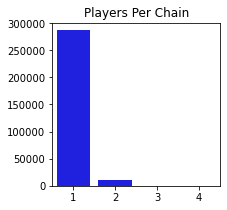

In [10]:
plt.figure(figsize = (3, 3))
plt.subplot
plt.title('Players Per Chain')
sns.countplot(x = players_per_chain, color = 'b')
plt.ylabel('')

Text(0, 0.5, '')

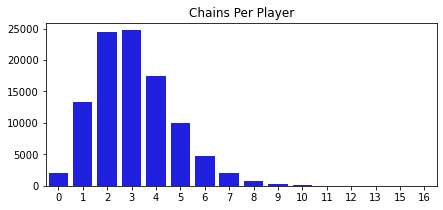

In [11]:
plt.figure(figsize = (7, 3))
plt.title('Chains Per Player')
sns.countplot(x = chains_per_player, color = 'b')
plt.yladata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAOMAAADSCAYAAAC4qHdEAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8QVMy6AAAACXBIWXMAAAsTAAALEwEAmpwYAAAPaElEQVR4nO3df5BdZX3H8fcnIWhKgJAmYEggyUBaIFRCiZhO/igFigGtYseMwKBRo2CFKU6pTnBsDQUqdkSsDj8KBYmK/CiQlrFEWH6VTouEBAImBodIYgiEhF8Bokib8O0fz3P17Pbu7t27u/c+e/N5zdzZc59z7jnfu5NPzrnnnv0eRQRm1n6j2l2AmSUOo1khHEazQjiMZoVwGM0K4TCaFcJhbDFJD0r6dLvrKNVgfj+Srpb0N0NdU6s4jMNA0kZJb0raIWmrpO9IGtfuuhohabqkyLXvyO9l8RCuf09JSyQ9LemXef3XS5o+2HVHxGcj4qIhKLMtHMbh82cRMQ74Q+A9wJfbVYikPZp42fhc/+nA30qaP0TbvA34IHAGsC9wFLAKOKGJGjuKwzjMIuI5YDlwZM95kg6RdL+klyW9JOlGSePzvC9Iur3H8t+W9M08va+k6yRtkfScpIsljc7zPiHpvyRdLukVYImkQyX9h6TX8rZuabD+h4G1tfolfUrSOkmvSrpb0rRKfSHpHElPA0/Xeb8nAn8KfCgiHo2InRHxWkRcERHXVRadlut/Q9I9kiZW1vEvkl7I7+MhSbMq826QdHGePk7SZknnS9qWf0+fbOQ9t4vDOMwkHQScAjxebzbwVeBA4HDgIGBJnvd9YH4lnHsAHwW+l+cvBXYChwJHAycB1c9a7wWeAfYHLgEuAu4B9gOmAt9uoHZJmgfMAh6XdCrwJeDPgUnAfwI39XjZqXnbR9RZ5YnAioh4tp9NnwF8Mte+J/DXlXnLgZl53mPAjX2s512kve8UYBFwhaT9+tl2+0SEH0P8ADYCO4DtwC+AK4Gxed6DwKd7ed2pwOOV58uBz+TpDwA/zdMHAG/V1pnHTgceyNOfADb1WPd3gWuAqf3UPh2IXPurwDrgLyv1LKosOwr4FTAtPw/g+D7WfS1wcz/bfxD4cuX554Af9bLs+LzNffPzG4CL8/RxwJvAHpXltwFz2/3vo7eH94zD59SIGB8R0yLicxHxZs8FJO0v6eZ8mPk6aW84sbLIUuDMPH0mv90rTgPGAFskbZe0Hfgn0t6ipufe54ukPfEKSWslfaqf+idGxH4RcXhEfKuy3X+sbPOVvM4pfWy36mVgcj/bBXihMv0rYByApNGSLpX08/z72lirtbftRcTOeusqkcPYXl8l/c/+7ojYhxQ4Veb/K/BuSUeS9oy1Q7JnSXvGiTnw4yNin4iYVXlttz/HiYgXIuIzEXEgcDZwpaRDB1jvs8DZlW2Oj4ixEfHfvW23h3uBYyVNHeB2a84APkQ63N2XtBeH7r+zEcthbK+9yYezkqYAX6jOjIhfk84+/oD0WWtTHt9C+vx3maR9JI3KJ4P+uLcNSVpQCcGrpNDsGmC9VwMX1E6a5JNICxp9cUTcC3QByyQdI2kPSXtL+mwDe2pIv6+3SHvY3wH+foD1F81hbK8LSV99vAb8O3BHnWWWAn/Abw9Raz5OOrnxU1K4bqPvQ8D3AI9I2gHcCZwXERsGUmxELAO+BtycDxPXACcPZB3AR4C7gFtI73sNMIe01+zPd0mfwZ8jve8fD3DbRVP+YGuFknQw8BTwroh4vd312PDxnrFgkkYBf0U6A+kgdrhmrsywFpC0F7CVdFg2oKtfbGTqd88o6Z2SVkh6Ip8SvzCPT5DUla8x7Kp+mSrpAknrJf1M0vsq48dI+kme9y1JyuPvkHRLHn9ElesUJS3M23ha0sIhffcFi4hfRsS4iJgV/X9Jbp2gvy8iSaeNx+XpMcAjwFzgH4DFeXwx8LU8fQTwBPAOYAbwc2B0nrcC+KO8zuXAyZUvdq/O06cBt+TpCaSrSCaQrhx5Btiv3V/O+uHHcDz63TNGsiM/HZMfQfq+Z2keX0q6eoQ8fnNEvBXpbN160ndLk4F9IuLhiAjSmbHqa2rrug04Ie813wd0RcQrEfEq6bS4D9msIzX0mTFfgLyKdB3kFRHxiKQDIn3fRURskVS7+mMK3U85b85j/5une47XXvNsXtdOSa8Bv1sdr/Oaan1nAWcB7LXXXsccdthhjbwts5ZbtWrVSxExqd68hsIYEbuA2fmi5WX5ipDe1LsaIvoYb/Y11fquIV13yZw5c2LlypV9lGfWPpJ+0du8AX21ERHbSRfyzge25kNP8s9tebHNpL8+qJkKPJ/Hp9YZ7/aa/NcJ+5Kue+xtXWYdp5GzqZMqf8YzlnRd4FOkqzhqZzcXAv+Wp+8ETstnSGeQ/txlRT6kfUPS3Px58OM9XlNb10eA+/PnyruBkyTtl8/WnpTHzDpOI4epk4Gl+XPjKODWiPihpIeBWyUtAjYBCwAiYq2kW0mXK+0EzsmHuQB/Qfozl7Gks6nL8/h1wPckrSftEU/L63pF0kXAo3m5v4uIVwbzhs1K1XGXw/kzo5VM0qqImFNvni+HMyvEbnE53IwZG9tdAhs2TG93CVY47xnNCuEwmhXCYTQrhMNoVgiH0awQDqNZIRxGs0I4jGaFcBjNCuEwmhXCYTQrhMNoVgiH0awQDqNZIRxGs0I4jGaFaKQh1UGSHpC0Lrf3Py+PL8l33F2dH6dUXuP2/mYD1Mhf+u8Ezo+IxyTtDayS1JXnXR4RX68uLOkIUkOpWcCBwL2Sfi83pbqK1Gz4x6R79M0n3yceeDUiDpV0GukegB+VNAH4Cun+fZG3fWfuLm7WURpp778lIh7L028A66jT1bvC7f3NmjCgz4z58PFo0s1vAM6V9KSk6yt3oeqtJf8UGmzvT7qj7YDa+0taKWnliy++OJC3ZFaMhsMoaRxwO/D5SDfuvAo4BJgNbAEuqy1a5+XD3t4/IuZExJxJk+rexsCseA2FUdIYUhBvjIg7ACJia0Tsioi3gWuBY/Pibu9v1oRGzqaK1PF7XUR8ozI+ubLYh4E1edrt/c2a0MjZ1HnAx4CfSFqdx74EnC5pNumwcSNwNri9v1mzdov2/m5ibKVwe3+zEcBhNCuEw2hWCIfRrBAOo1khHEazQjiMZoVwGM0K4TCaFcJhNCuEw2hWCIfRrBAOo1khHEazQjiMZoVwGM0K4TCaFcJhNCvEYNr7T5DUldvud1X6prq9v1kTGtkz1tr7Hw7MBc7JLfwXA/dFxEzgvvy8Z3v/+cCVkkbnddXa+8/Mj1p38N+09wcuJ7X3p9Le/72kVpBfqYberJMMpr1/tSX/Urq36nd7f7MBGkx7/wNyL1Tyz/3zYm7vb9aEwbT373XROmNu72/Wj6bb+wNba13F889tedzt/c2a0HR7f7q35F9I91b9bu9vNkCDae9/KXCrpEXAJmABuL2/WbPc3r9F3N7fwO39zUYEh9GsEA6jWSEcRrNCOIxmhXAYzQrhMJoVwmE0K4TDaFYIh9GsEA6jWSEcRrNCOIxmhXAYzQrhMJoVwmE0K4TDaFYIh9GsEI00pLpe0jZJaypjSyQ9J2l1fpxSmefW/mZNaGTPeAP1u3hfHhGz8+MucGt/s8FopL3/Q6SObY1wa3+zJg3mM+O5kp7Mh7G1PVbLW/uD2/tbZ2g2jFcBhwCzgS3AZXm85a39we39rTM0FcaI2BoRuyLibeBa0mc6cGt/s6Y1FcbaPTayDwO1M61u7W/WpH7b+0u6CTgOmChpM+kM53GSZpMOGzcCZ4Nb+5sNhtv7t4jb+xu4vb/ZiOAwmhXCYTQrhMNoVgiH0awQDqNZIRxGs0I4jGaFcBjNCuEwmhXCYTQrhMNoVgiH0awQDqNZIRxGs0I4jGaFcBjNCuEwmhWi2fb+EyR15bb7XdVO327vb9acZtv7Lwbui4iZwH35udv7mw1Cs+39qy35l9K9Vb/b+5s1odnPjAfkXqjkn/vn8ba09zfrBEN9Aqct7f19rw3rBM2GcWutq3j+uS2Pt6W9v++1YZ2g2TBWW/IvpHurfrf3N2tCs+39LwVulbQI2AQsALf3NxsMt/dvEbf3N3B7f7MRwWE0K4TDaFYIh9GsEA6jWSEcRrNCOIxmhXAYzQrhMJoVwmE0K4TDaFYIh9GsEA6jWSEcRrNCOIxmhXAYzQrhMJoVwmE0K8SgwihpY27Zv1rSyjzWktb/Zp1mKPaMfxIRsyt9PYa99b9ZJxqOw9RWtP436ziDDWMA90haJemsPNaK1v9mHaffvqn9mBcRz0vaH+iS9FQfyw5l6//uK07/EZwFcPDBB/ddsVmhBrVnjIjn889twDLSrdta0fq/Zx1u728jXtNhlLSXpL1r06T2+2toTet/s44zmMPUA4Bl+XzKHsAPIuJHkh5lmFv/m3WipsMYEc8AR9UZfxk4oZfXXAJcUmd8JXBknfFfk8Ns1ul8BY5ZIRxGs0I4jGaFcBjNCuEwmhXCYTQrhMNoVgiH0awQDqNZIRxGs0I4jGaFcBjNCuEwmhXCYTQrhMNoVgiH0awQg21IZUNkxoyN7S4BgA0bpre7hN2W94xmhRgRYZQ0P98SYL2kxe2ux2w4FB/GfAuAK4CTgSOA0/OtAsw6SvFhJPViXR8Rz0TE/wA3k9r+m3WUkRDG3m4LYNZRRsLZ1H5b/Ffb+wM7JP1siGuYCLw0mBW06HY9u02dLTIcdU7rbcZICGNvtwX4jYi4BrhmuAqQtLJyy7tiuc6h1eo6R8Jh6qPATEkzJO1J6ip+Z5trMhtyxe8ZI2KnpHOBu4HRwPURsbbNZZkNueLDCBARdwF3tbGEYTsEHmKuc2i1tE75pk5mZRgJnxnNdgsOYx8kXS9pm6Q17a6lL5IOkvSApHWS1ko6r9011SPpnZJWSHoi13lhu2vqjaTRkh6X9MNWbdNh7NsNwPx2F9GAncD5EXE4MBc4p9BLBt8Cjo+Io4DZwHxJc9tbUq/OA9a1coMOYx8i4iHq3La8NBGxJSIey9NvkP4RFXeVUiQ78tMx+VHcSQtJU4H3A//cyu06jB1G0nTgaOCRNpdSVz78Ww1sA7oiosQ6vwl8EXi7lRt1GDuIpHHA7cDnI+L1dtdTT0TsiojZpCupjpX0/+5Y3U6SPgBsi4hVrd62w9ghJI0hBfHGiLij3fX0JyK2Aw9S3mfyecAHJW0k/YXQ8ZK+34oNO4wdQJKA64B1EfGNdtfTG0mTJI3P02OBE4Gn2lpUDxFxQURMjYjppEsv74+IM1uxbYexD5JuAh4Gfl/SZkmL2l1TL+YBHyP9L746P05pd1F1TAYekPQk6Zrjroho2VcHpfMVOGaF8J7RrBAOo1khHEazQjiMZoVwGM0K4TCaFcJhNCuEw2hWiP8DmvgmklKT4mUAAAAASUVORK5CYII=bel('')

Text(0, 0.5, '')

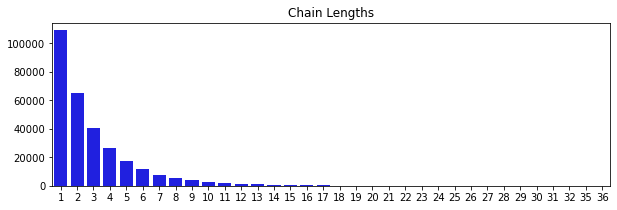

In [12]:
plt.figure(figsize = (10, 3))
plt.title('Chain Lengths')
sns.countplot(x = chain_lens, color = 'b')
plt.ylabel('')

Total number of chains:

In [13]:
len(cand_chains)

297453

Total number of runs:

In [14]:
nruns

873340

Proportion of chains containing runs from more than one player:

In [15]:
(players_per_chain > 1).sum() / len(cand_chains)

0.03710165975801219

Spearman rank correlation between chain length and players per chain:

In [16]:
sps.spearmanr(chain_lens, players_per_chain)

SpearmanrResult(correlation=0.19945974176987227, pvalue=0.0)

Proportion of players represented in chain data:

In [17]:
(chains_per_player > 0).sum() / nplayers

0.97974

Proportion of represented players that are represented in multiple chains:

In [18]:
(chains_per_player > 1).sum() / (chains_per_player > 0).sum()

0.8639230816339029

Repeat diagnostic for chains meeting the minumum length threshold.

In [19]:
long_chains = [ch for ch in cand_chains if len(ch) >= min_len]

In [20]:
players_per_chain = np.zeros(len(long_chains), dtype = int)
chains_per_player = np.zeros(nplayers, dtype = int)
chain_lens = np.zeros(len(long_chains), dtype = int)
nruns = 0

for i, ch in enumerate(long_chains):
    nruns += len(ch)
    players = set()
    for r in ch:
        players.add(r[5])
    players_per_chain[i] = len(players)
    
    for p in players:
        chains_per_player[p] += 1
        
    chain_lens[i] = len(ch)

Text(0, 0.5, '')

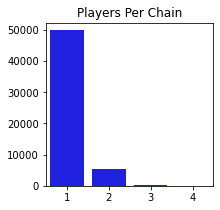

In [21]:
plt.figure(figsize = (3, 3))
plt.title('Players Per Chain')
sns.countplot(x = players_per_chain, color = 'b')
plt.ylabel('')

Text(0, 0.5, '')

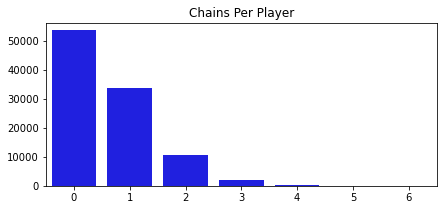

In [22]:
plt.figure(figsize = (7, 3))
plt.title('Chains Per Player')
sns.countplot(x = chains_per_player, color = 'b')
plt.ylabel('')

Text(0, 0.5, '')

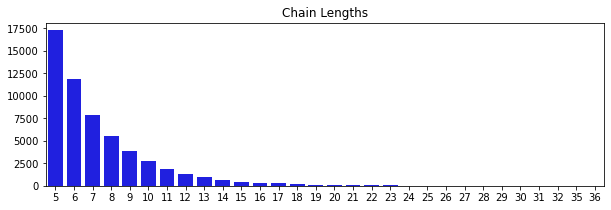

In [23]:
plt.figure(figsize = (10, 3))
plt.title('Chain Lengths')
sns.countplot(x = chain_lens, color = 'b')
plt.ylabel('')

Total number of chains:

In [24]:
len(long_chains)

55482

Total remaining runs:

In [25]:
nruns

404798

Proportion of chains containing runs from more than one player:

In [26]:
(players_per_chain > 1).sum() / len(long_chains)

0.10342092931040697

Spearman rank correlation between chain length and players per chain:

In [27]:
sps.spearmanr(chain_lens, players_per_chain)

SpearmanrResult(correlation=0.06768503076568635, pvalue=2.392730891830726e-57)

Proportion of players represented in chain data:

In [28]:
(chains_per_player > 0).sum() / nplayers

0.46496

Proportion of represented players that are represented in multiple chains:

In [29]:
(chains_per_player > 1).sum() / (chains_per_player > 0).sum()

0.27193737095664144

Perform back-collision pruning.

In [30]:
# transfer isolated runs in the chaining dict to the search dict
for r_arr in chain_data.values():
    for r in r_arr:
        target_exp = r[1] + r[2]
        if target_exp in search_data:
            search_data[target_exp].append(r)
        else:
            search_data[target_exp] = [r]

In [31]:
# prune chains after back-collisions
for i in range(len(cand_chains)):
    ch = cand_chains[i]
    for j in range(1, len(ch)):
        trunc = False
        colls = search_data.get(ch[j][1])
        if colls == None: 
            continue

        for r in colls:
            if links(r, ch[j]):
                trunc = True
                break

        if trunc:
            cand_chains[i] = ch[:j]
            break

Diagnose chain integrity after back-collision pruning.

In [32]:
players_per_chain = np.zeros(len(cand_chains), dtype = int)
chains_per_player = np.zeros(nplayers, dtype = int)
chain_lens = np.zeros(len(cand_chains), dtype = int)
nruns = 0

for i, ch in enumerate(cand_chains):
    nruns += len(ch)
    players = set()
    for r in ch:
        players.add(r[5])
    players_per_chain[i] = len(players)
    
    for p in players:
        chains_per_player[p] += 1
        
    chain_lens[i] = len(ch)

Text(0, 0.5, '')

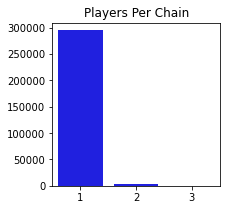

In [33]:
plt.figure(figsize = (3, 3))
plt.title('Players Per Chain')
sns.countplot(x = players_per_chain, color = 'b')
plt.ylabel('')

Text(0, 0.5, '')

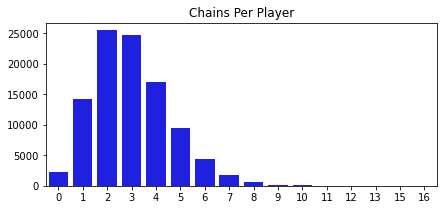

In [34]:
plt.figure(figsize = (7, 3))
plt.title('Chains Per Player')
sns.countplot(x = chains_per_player, color = 'b')
plt.ylabel('')

Text(0, 0.5, '')

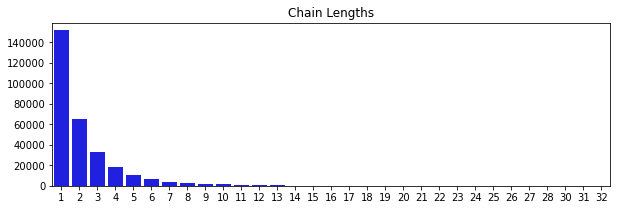

In [35]:
plt.figure(figsize = (10, 3))
plt.title('Chain Lengths')
sns.countplot(x = chain_lens, color = 'b')
plt.ylabel('')

Total number of chains:

In [36]:
len(cand_chains)

297453

Total remaining runs:

In [37]:
nruns

660257

Proportion of chains containing runs from more than one player:

In [38]:
(players_per_chain > 1).sum() / len(cand_chains)

0.010011665708532104

Spearman rank correlation between chain length and players per chain:

In [39]:
sps.spearmanr(chain_lens, players_per_chain)

SpearmanrResult(correlation=0.11088635277909469, pvalue=0.0)

Proportion of players represented in chain data:

In [40]:
(chains_per_player > 0).sum() / nplayers

0.97757

Proportion of represented players that are represented in multiple chains:

In [41]:
(chains_per_player > 1).sum() / (chains_per_player > 0).sum()

0.85502828441953

Repeat diagnostic for chains meeting the minumum length threshold.

In [42]:
long_chains = [ch for ch in cand_chains if len(ch) >= min_len]

In [43]:
players_per_chain = np.zeros(len(long_chains), dtype = int)
chains_per_player = np.zeros(nplayers, dtype = int)
chain_lens = np.zeros(len(long_chains), dtype = int)
nruns = 0

for i, ch in enumerate(long_chains):
    nruns += len(ch)
    players = set()
    for r in ch:
        players.add(r[5])
    players_per_chain[i] = len(players)
    
    for p in players:
        chains_per_player[p] += 1
        
    chain_lens[i] = len(ch)

Text(0, 0.5, '')

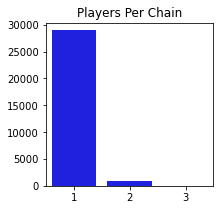

In [44]:
plt.figure(figsize = (3, 3))
plt.title('Players Per Chain')
sns.countplot(x = players_per_chain, color = 'b')
plt.ylabel('')

Text(0, 0.5, '')

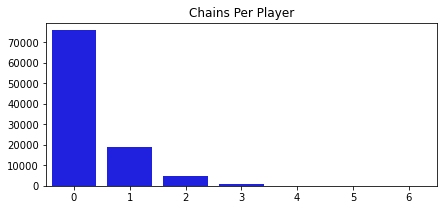

In [45]:
plt.figure(figsize = (7, 3))
plt.title('Chains Per Player')
sns.countplot(x = chains_per_player, color = 'b')
plt.ylabel('')

Text(0, 0.5, '')

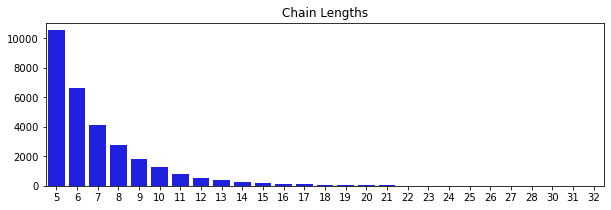

In [46]:
plt.figure(figsize = (10, 3))
plt.title('Chain Lengths')
sns.countplot(x = chain_lens, color = 'b')
plt.ylabel('')

Total number of chains:

In [47]:
len(long_chains)

29783

Total remaining runs:

In [48]:
nruns

207943

Proportion of chains containing runs from more than one player:

In [49]:
(players_per_chain > 1).sum() / len(long_chains)

0.029244871235268442

Spearman rank correlation between chain length and players per chain:

In [50]:
sps.spearmanr(chain_lens, players_per_chain)

SpearmanrResult(correlation=0.005974068358904623, pvalue=0.3025615374875444)

Proportion of players represented in chain data:

In [51]:
(chains_per_player > 0).sum() / nplayers

0.24209

Proportion of represented players that are represented in multiple chains:

In [52]:
(chains_per_player > 1).sum() / (chains_per_player > 0).sum()

0.22656863150068157